In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
model_version = 'v8.0'

In [4]:
with open('data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [5]:
df = pd.read_csv(f"data/processed/spectrometry_photometry.csv")

X = df[spectro_cols + photo_cols + generic_cols]
y = df[target_col]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.0001)

inputs = keras.Input(shape=(input_shape,))

x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_32')(inputs)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_64')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_128')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_256')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_32.2')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 58)]              0         
                                                                 
 Dense_32 (Dense)            (None, 32)                1888      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 Dense_64 (Dense)            (None, 64)                2112      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0   

In [10]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.4,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/1000
2932/2932 [==============================] - 29s 10ms/step - loss: 30.4083 - mae: 3.4550 - mse: 26.6550 - mape: 32.7391 - val_loss: 9.6552 - val_mae: 1.9243 - val_mse: 6.0711 - val_mape: 18.0363
Epoch 2/1000
2932/2932 [==============================] - 39s 13ms/step - loss: 11.6707 - mae: 2.0810 - mse: 8.2484 - mape: 19.7022 - val_loss: 4.6873 - val_mae: 0.9646 - val_mse: 1.4264 - val_mape: 8.9909
Epoch 3/1000
2932/2932 [==============================] - 36s 12ms/step - loss: 8.6862 - mae: 1.7922 - mse: 5.5825 - mape: 16.9494 - val_loss: 3.3662 - val_mae: 0.5069 - val_mse: 0.4251 - val_mape: 4.7589
Epoch 4/1000
2932/2932 [==============================] - 32s 11ms/step - loss: 7.2330 - mae: 1.6601 - mse: 4.4543 - mape: 15.6981 - val_loss: 2.8788 - val_mae: 0.4259 - val_mse: 0.2756 - val_mape: 3.9998
Epoch 5/1000
2932/2932 [==============================] - 36s 12ms/step - loss: 6.4555 - mae: 1.5807 - mse: 4.0447 - mape: 14.9408 - val_loss: 2.4572 - val_mae: 0.4324 - val_ms

In [11]:
y_pred_full = model.predict(X_test_scaled)

# Evaluate accuracy metrics
mae = mean_absolute_error(y_test, y_pred_full)
r2 = r2_score(y_test, y_pred_full)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_full))

print(f"Spectrometry and Photometry Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

2094/2094 [==============================] - 4s 2ms/step
Spectrometry and Photometry Model Evaluation:
Mean Absolute Error (MAE): 0.1145
Root Mean Squared Error (RMSE): 0.2175
R² Score: 0.8904


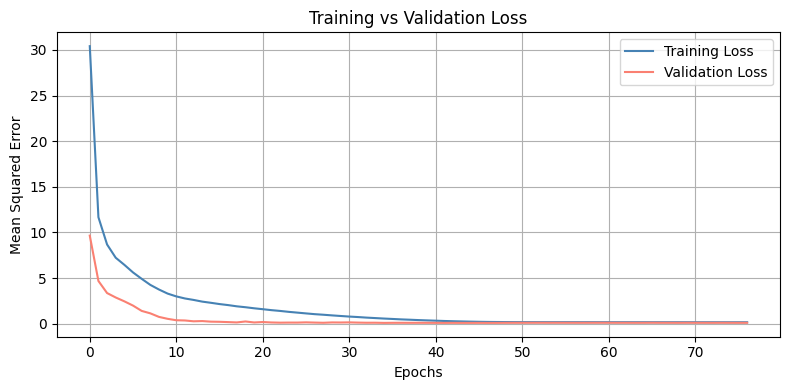

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='steelblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='salmon')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

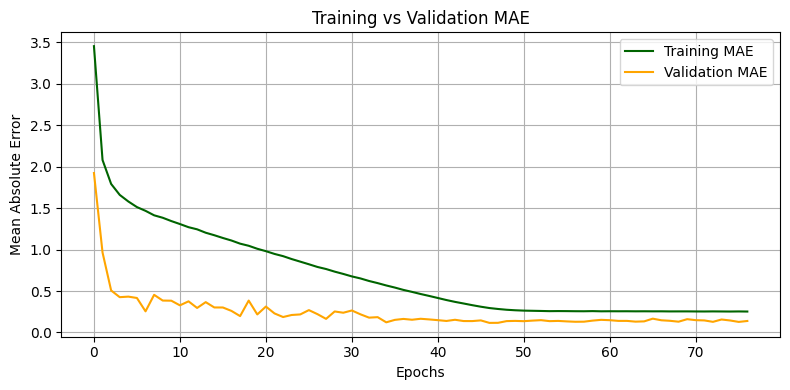

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['mae'], label='Training MAE', color='darkgreen')
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Training vs Validation MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

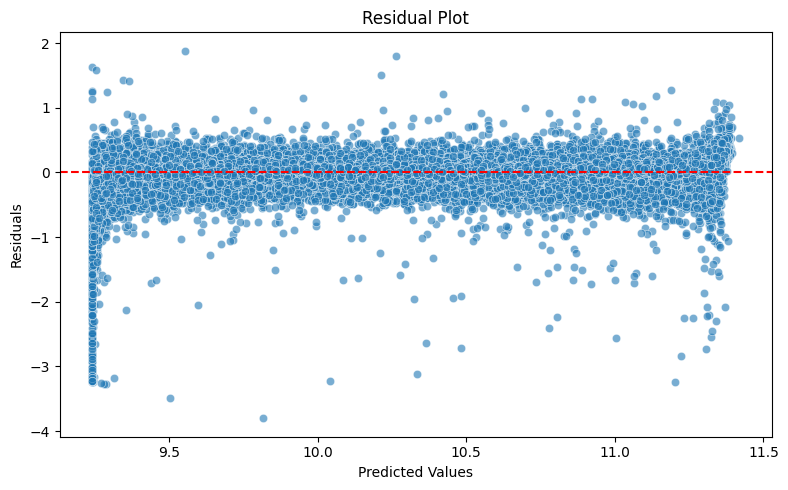

In [14]:
y_pred_flat = y_pred_full.ravel()
y_test_flat = y_test.iloc[:, 0].values.ravel()

residuals = y_test_flat - y_pred_flat

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_flat, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

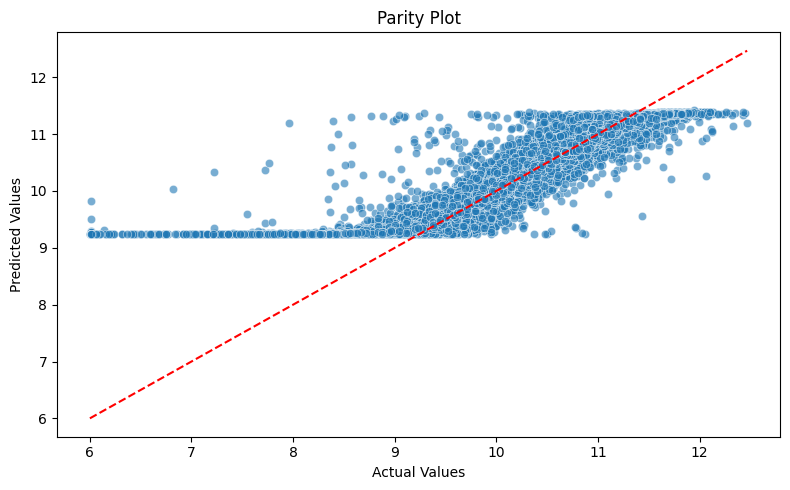

In [15]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.tight_layout()
plt.show()


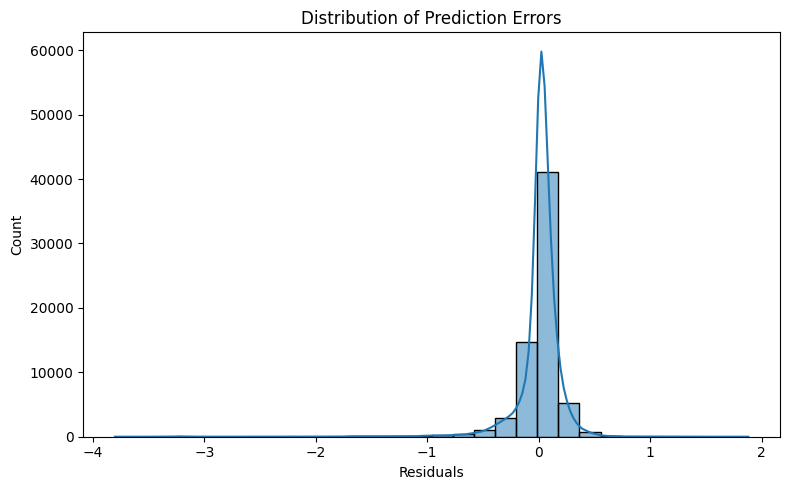

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Distribution of Prediction Errors")
plt.tight_layout()
plt.show()

In [17]:
def plot_visualizations(history, y_test, y_pred):
    y_pred_flat = y_pred.ravel()
    y_test_flat = y_test.iloc[:, 0].values.ravel()

    residuals = y_test_flat - y_pred_flat

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred_flat, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Parity Plot")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.title("Distribution of Prediction Errors")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss', color='steelblue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='salmon')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['mae'], label='Training MAE', color='darkgreen')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Absolute Error")
    plt.title("Training vs Validation MAE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [19]:
def plot_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

In [20]:
plot_metrics(y_test, y_pred_full)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.1145
Root Mean Squared Error (RMSE): 0.2175
R² Score: 0.8904


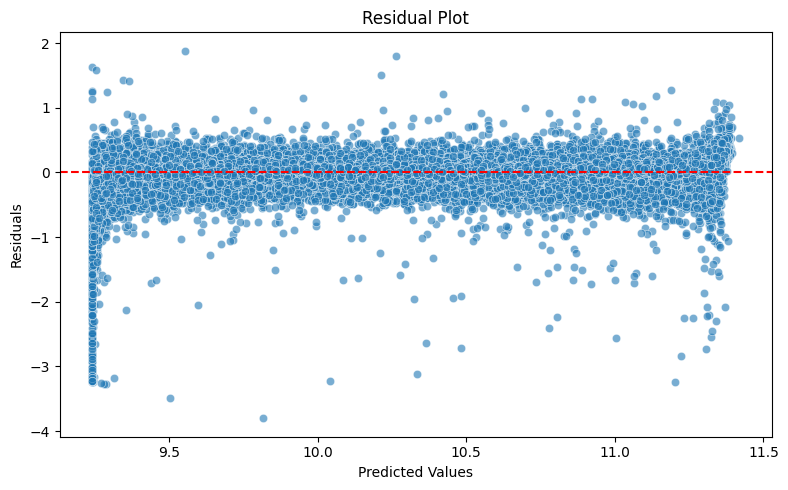

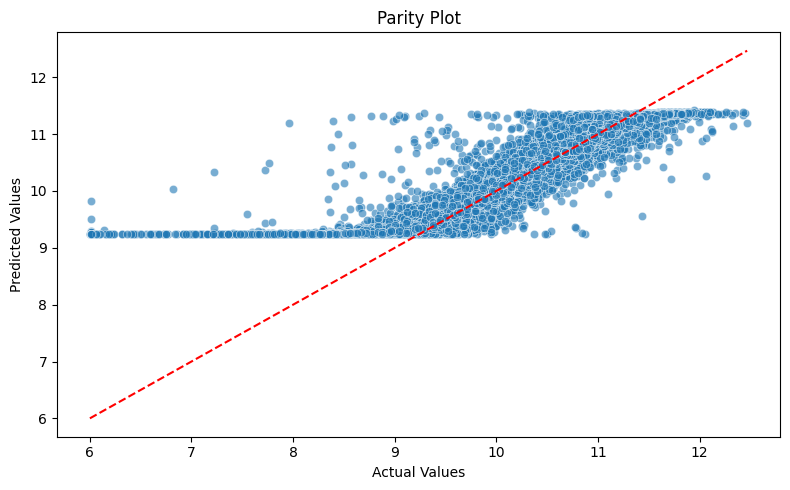

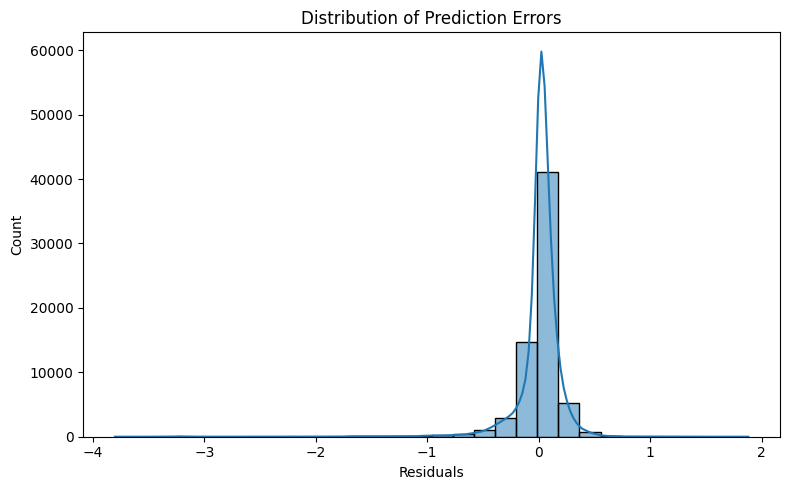

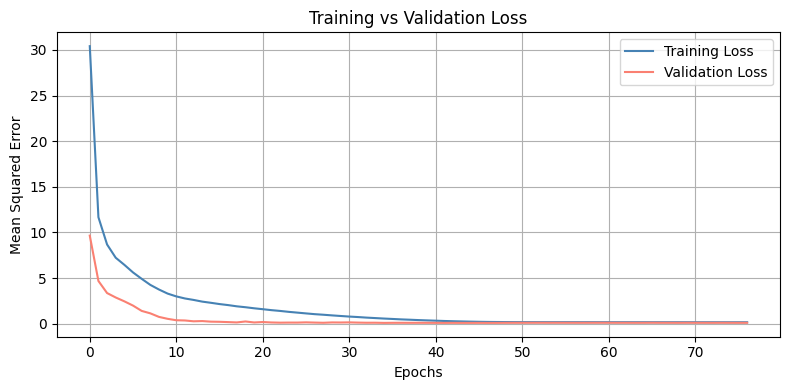

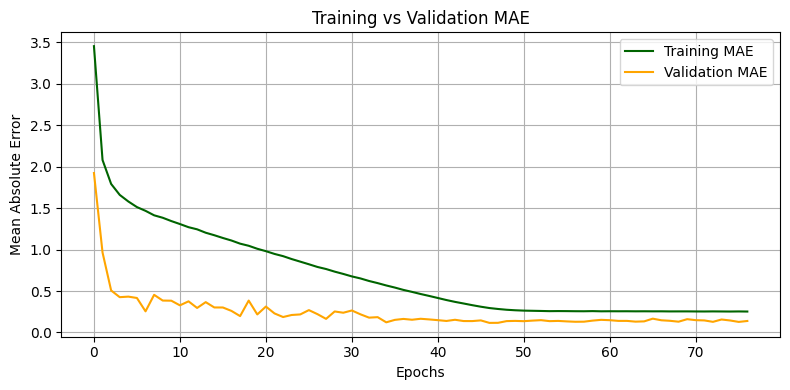

In [18]:
plot_visualizations(history, y_test, y_pred_full)